## Chebyshev-KAN for MNIST

In [1]:
# !pip install --upgrade scipy
# !pip install pymoo

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from ChebyKANLayer import ChebyKANLayer
import pandas as pd
from sklearn.metrics import (
            f1_score,
            precision_score,
            recall_score,
            roc_auc_score,
            top_k_accuracy_score,
        )
import matplotlib.pyplot as plt
from gfo import GFOProblem, SOCallback, blocker, build_rand_blocks, get_model_params, set_model_state

In [7]:
# Construct a ChebyKAN for MNIST
class MNISTChebyKAN(nn.Module):
    def __init__(self):
        super(MNISTChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(28*28, 32, 8)
        self.ln1 = nn.LayerNorm(32) # To avoid gradient vanishing caused by tanh
        self.chebykan2 = ChebyKANLayer(32, 16, 8)
        self.ln2 = nn.LayerNorm(16)
        self.chebykan3 = ChebyKANLayer(16, 10, 8)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.chebykan1(x)
        # x = self.ln1(x)
        x = self.chebykan2(x)
        # x = self.ln2(x)
        x = self.chebykan3(x)
        return x

In [8]:
# Load MNIST
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

In [9]:
def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    f1 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            f1 += f1_score(target.view_as(pred).cpu().numpy(), pred.cpu().numpy(), average='macro')


    return total_loss / len(test_loader), correct / len(test_loader.dataset), f1 / len(test_loader) # (Loss, Accuracy, F1-score)

# Differential Evolution

In [ ]:
from scipy.optimize import rosen, differential_evolution

# Parameter Setting
NP = 100 # Number of population
block_size = 100
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTChebyKAN().to(device)
init_params = get_model_params(model)
D = len(init_params)
print(f"Original dims: {D} D")

import os
import pickle 

codebook = {}
if os.path.exists(f'out/codebook_D{D}_blocksize{block_size}.pkl'):
    with open(f'out/codebook_D{D}_blocksize{block_size}.pkl', 'rb') as f:
        codebook = pickle.load(f)
else:
    codebook = build_rand_blocks(D, block_size=block_size)
    
    with open(f'out/codebook_D{D}_blocksize{block_size}.pkl', 'wb') as f:
        pickle.dump(codebook, f)

bD = len(codebook)
print(f"Blocked dims: {bD} D")
# Population initialization
# Uniform distribution
init_pop = np.random.uniform(low=-2, high=2, size=(NP, bD))
# Normal distribution
# init_pop = np.random.normal(loc=init_params.mean(), scale=0.1, size=(NP, bD))
# Block the initial params from model
init_params = blocker(init_params, codebook)
init_pop[0] = init_params.copy()
# One center-based solution to accelerate population
init_pop[-1] = init_pop[:-1].mean(0)
# Define gradient-free optimization problem object
random_indices = np.random.choice(
            np.arange(len(trainset)), size=1024, replace=False
        )
random_dataset = Subset(trainset, random_indices)
data_loader = DataLoader(random_dataset, batch_size=128, shuffle=True)
problem = GFOProblem(n_var=bD, model=model, dataset=trainset, test_loader=test_loader, # train_loader=data_loader, 
                      set_model_state=set_model_state,
                      sample_size=1000, device=device, criterion="f1",
                      block=True, codebook=codebook, orig_dims=D)

# Save history and plot in the out paths
csv_path = f"out/block_bs{block_size}_gfo_f1_1000s_de_scipy_hist.csv"
plt_path = f"out/block_bs{block_size}_gfo_f1_1000s_de_scipy_plt.pdf"
df = pd.DataFrame({
            'n_step': [1],
            'f_best': [problem.scipy_fitness_func(init_pop[-1])],
            'f_avg': [problem.scipy_fitness_func(init_pop[-1])],
            'f_std': [0],
            'test_f1_best': problem.test_func(init_pop[-1]),
        })
df.to_csv(csv_path, index=False)

de_callback = SOCallback(problem=problem, csv_path=csv_path, plt_path=plt_path)
result = differential_evolution(problem.scipy_fitness_func, bounds=[(-2, 2)]*bD, strategy='rand1bin', maxiter=int(1e+6)//NP, popsize=NP, init=init_pop,
                                tol=1e-3, mutation=(0.5, 1.5), recombination=0.9, seed=None,
                                callback=de_callback.scipy_func,
                                disp=True, polish=False, atol=0, updating='deferred', workers=1, vectorized=False)


print("Best solution found: \nX = %s\nF = %s" % (result.x, result.fun))

In [ ]:
# Save the best solution model parameters state
best_X = result.x.copy()
if len(result.x) != D:
    best_X = problem.unblocker(best_X)
set_model_state(model, best_X)
torch.save(model.state_dict(), "out/block_bs{block_size}_gfo_f1_128batch_de_scipy_model.pth")

# CMA-ES

In [11]:
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.optimize import minimize

# Parameter Setting
NP = 100
block_size = 1000
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTChebyKAN().to(device)
init_params = get_model_params(model)
D = len(init_params)
print(f"Original dims: {D} D")

import os
import pickle 

codebook = {}
if os.path.exists(f'out/codebook_D{D}_blocksize{block_size}.pkl'):
    with open(f'out/codebook_D{D}_blocksize{block_size}.pkl', 'rb') as f:
        codebook = pickle.load(f)
else:
    codebook = build_rand_blocks(D, block_size=block_size)
    
    with open(f'out/codebook_D{D}_blocksize{block_size}.pkl', 'wb') as f:
        pickle.dump(codebook, f)

bD = len(codebook)
print(f"Blocked dims: {bD} D")
# init_pop = np.random.uniform(low=-0.5, high=0.5, size=(NP, bD))
init_params = blocker(init_params, codebook)
init_pop = np.random.normal(loc=init_params, scale=0.1, size=(NP, bD))
init_pop[0] = init_params.copy()
init_pop[-1] = init_pop[:-1].mean(0)

random_indices = np.random.choice(
            np.arange(len(trainset)), size=1024, replace=False
        )
random_dataset = Subset(trainset, random_indices)
data_loader = DataLoader(random_dataset, batch_size=128, shuffle=True)
problem = GFOProblem(n_var=bD, model=model, dataset=trainset, test_loader=test_loader, # train_loader=data_loader, 
                      set_model_state=set_model_state,
                      sample_size=1000, device=device, criterion="f1",
                      block=True, codebook=codebook, orig_dims=D)
out={"F": []}
problem._evaluate(init_pop[[0, -1]], out=out)
print(out)

algorithm = CMAES(
    x0=init_pop[-1],
    sigma=0.1,
    tolconditioncov=0,
    tolfacupx=np.inf,
    tolupsigma=np.inf,
    tolfun=0,
    tolfunhist=0,
    tolstagnation=np.inf,
    tolx=0,
    restarts=4, 
    bipop=True,
)

csv_path = f"out/8degree_block_bs{block_size}_gfo_f1_1000s_cmaes_hist.csv"
plt_path = f"out/8degree_block_bs{block_size}_gfo_f1_1000s_cmaes_plt.pdf"
df = pd.DataFrame({
            'n_step': [1],
            'f_best': [out["F"][1]],
            'f_avg': [out["F"][1]],
            'f_std': [0],
            'test_f1_best': problem.test_func(init_pop[-1]),
        })
df.to_csv(csv_path, index=False)

res = minimize(problem,
               algorithm,
               ('n_eval', 100000),
               callback=SOCallback(csv_path=csv_path, plt_path=plt_path),
               seed=None,
               verbose=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Original dims: 231936 D
Blocked dims: 232 D
{'F': array([0.98233381, 0.95507405])}
n_gen  |  n_eval  |     f_avg     |     f_min     |     f_gap     | run  |   fpop   | n_pop |     sigma     | min_std  | max_std  |   axis  
     1 |        1 |  0.9552378090 |  0.9552378090 |  0.9552378090 |    1 |  0.95524 |    20 |  0.1000000000 |  0.10000 |  0.10000 |  1.00005
     2 |       21 |  0.9555997224 |  0.9305626110 |  0.9305626110 |    1 |  0.93056 |    20 |  0.0976817788 |  0.09766 |  0.09772 |  1.00005
     3 |       41 |  0.9563992757 |  0.9305626110 |  0.9305626110 |    1 |  0.93361 |    20 |  0.0956661240 |  0.09564 |  0.09571 |  1.00005
     4 |       61 |  0.9546294434 |  0.9190045601 |  0.9190045601 |    1 |  0.91900 |    20 |  0.0938465278 |  0.09382 |  0.09388 |  1.01100
     5 |       81 |  0.9548122956 |  0.9190045601 |  0.9190045601 |    1 |  0.93326 |    20 |  0.0921680395 |  0.09213 |  0.09221 |  1.01100
     6 |      101 |  0.9490584056 |  0.9190045601 |  0.9190045601 |    

KeyboardInterrupt: 

In [12]:
# Save the best solution model parameters state
best_X = res.X.copy()
if len(res.X) != D:
    best_X = problem.unblocker(best_X)
set_model_state(model, best_X)
torch.save(model.state_dict(), f"out/8degree_block_bs{block_size}_gfo_f1_1000s_cmaes_model.pth")

## Take a peek at what the Chebyshev Polynomials look like

In [13]:
def chebyshev_polynomials(x, degree):
    # T_0(x) and T_1(x)
    if degree == 0:
        return np.ones_like(x)
    elif degree == 1:
        return x
    else:
        Tn_2 = np.ones_like(x)
        Tn_1 = x
        Tn = None
        for n in range(2, degree + 1):
            Tn = 2 * x * Tn_1 - Tn_2
            Tn_2, Tn_1 = Tn_1, Tn
        return Tn

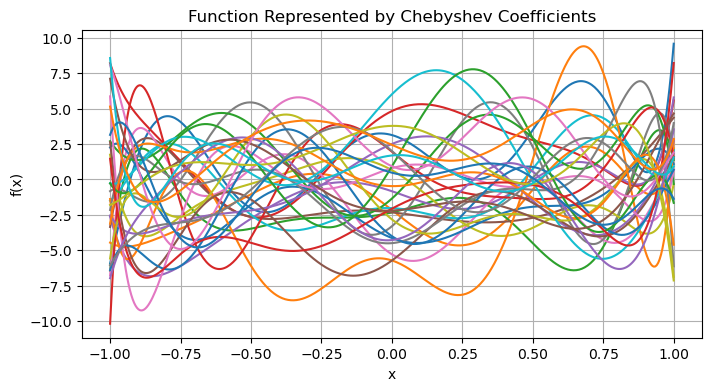

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.chebykan1.cheby_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[28 * 28 // 2]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * chebyshev_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Chebyshev Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

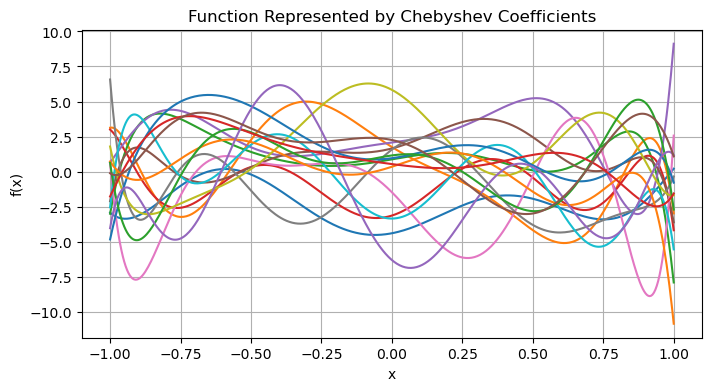

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.chebykan2.cheby_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[16]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * chebyshev_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Chebyshev Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

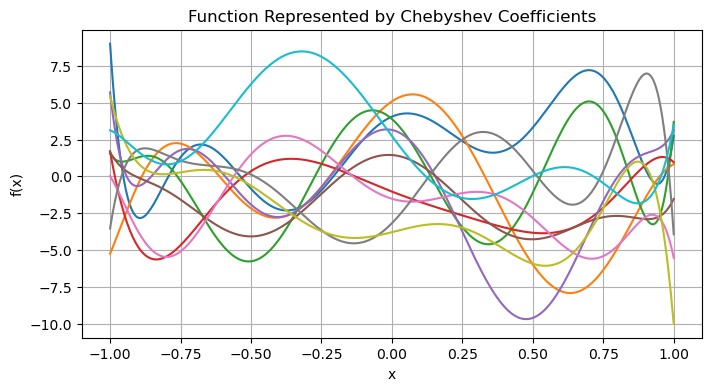

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.chebykan3.cheby_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[8]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * chebyshev_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Chebyshev Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()